In [11]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class EMNISTDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.X = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
        self.y = df.iloc[:, 0].values.astype(np.int64) - 1  # oduzto 1 da bi bilo od0 do 25
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [12]:
from torch.utils.data import DataLoader

train_dataset = EMNISTDataset("emnist-letters-train.csv")
test_dataset = EMNISTDataset("emnist-letters-test.csv")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 na 14x14
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)  # Dodat sloj u odnosu na prosli kod
        self.pool3 = nn.MaxPool2d(2, 2)  # 7x7 -> 3x3
        self.dropout = nn.Dropout(p=0.5)
        self.fcc1 = nn.Linear(128 * 3 * 3, 128)  # Prilagođeno za treći sloj
        self.fcc2 = nn.Linear(128, 26)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fcc1(x))
        x = self.dropout(x)
        x = self.fcc2(x)
        return x





False
None
Koristi se: cpu
Epoch 1, Loss: 666.8341, Val Acc: 87.78%
Epoch 1, Loss: 666.8341, Val Acc: 87.78%
Epoch 2, Loss: 312.9259, Val Acc: 88.45%
Epoch 2, Loss: 312.9259, Val Acc: 88.45%
Epoch 3, Loss: 252.6217, Val Acc: 91.11%
Epoch 3, Loss: 252.6217, Val Acc: 91.11%
Epoch 4, Loss: 225.1641, Val Acc: 91.61%
Epoch 4, Loss: 225.1641, Val Acc: 91.61%
Epoch 5, Loss: 205.7071, Val Acc: 92.10%
Epoch 5, Loss: 205.7071, Val Acc: 92.10%
Epoch 6, Loss: 188.9228, Val Acc: 92.11%
Epoch 6, Loss: 188.9228, Val Acc: 92.11%
Epoch 7, Loss: 175.2812, Val Acc: 92.70%
Epoch 7, Loss: 175.2812, Val Acc: 92.70%
Epoch 8, Loss: 168.1409, Val Acc: 92.53%
Epoch 8, Loss: 168.1409, Val Acc: 92.53%
Epoch 9, Loss: 157.9112, Val Acc: 92.85%
Epoch 9, Loss: 157.9112, Val Acc: 92.85%
Epoch 10, Loss: 150.9387, Val Acc: 92.80%
Epoch 10, Loss: 150.9387, Val Acc: 92.80%
Epoch 11, Loss: 144.2698, Val Acc: 92.90%
Epoch 11, Loss: 144.2698, Val Acc: 92.90%
Epoch 12, Loss: 139.0224, Val Acc: 93.14%
Epoch 12, Loss: 139.0224,

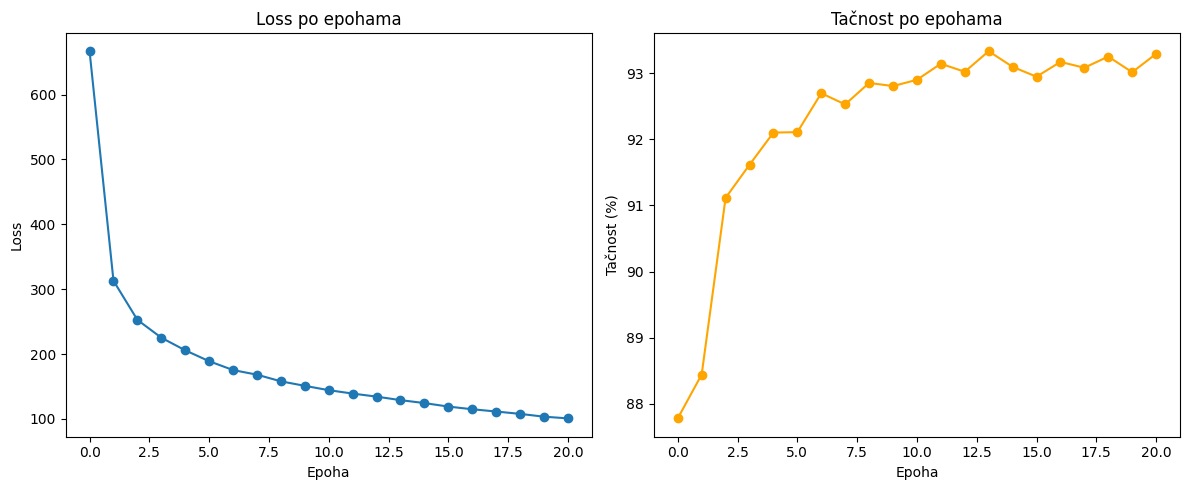

In [19]:
import os
import matplotlib.pyplot as plt
import datetime

#gpu
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print("Koristi se:", device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 150
losses = []
accuracies = []

weights_dir = "weights-convolutional 1"

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


early_stop_patience = 4
min_improve = 0.3
best_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    losses.append(total_loss)
    accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), os.path.join(weights_dir, f"model_epoch_{epoch+1}_{timestamp}.pth"))

    # Early stopping logika
    if epoch >= early_stop_patience:
        recent_accs = accuracies[-early_stop_patience-1:]
        if max(recent_accs) - min(recent_accs) < min_improve:
            print(f"Tačnost se nije poboljšala više od {min_improve}% u poslednjih {early_stop_patience} epoha.")
            break

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, marker='o')
plt.title('Loss po epohama')
plt.xlabel('Epohа')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(accuracies, marker='o', color='orange')
plt.title('Tačnost po epohama')
plt.xlabel('Epohа')
plt.ylabel('Tačnost (%)')
plt.tight_layout()
plt.show()